In [13]:
from time import time
from numpy import exp, sqrt, log
from random import gauss, seed

#Params
S0 = 100.
K = 105.
T = 1.
r = 0.05
sigma = 0.2
M = 50
dt = T / M
I = 250000

In [11]:
#Pure Python
seed(20000)
t0 = time()
S = []
for i in range(I):
    path = []
    for t in range(M+1):
        if t == 0:
            path.append(S0)
        else:
            z = gauss(0.0, 1.)
            St = path[t-1] * exp((r - 0.5 * sigma ** 2) * dt + sigma * sqrt(dt) * z)
            path.append(St)

    S.append(path)

C0 = exp(-r * T) * sum([max(path[-1] - K, 0) for path in S]) / I    
tpy = time() - t0

In [12]:
print(C0)
print(tpy)

7.99904488818
43.8648841381


In [21]:
#Numpy
import numpy as np
np.random.seed(20000)
t0 = time()

S = np.zeros((M + i, I))
S[0] = S0
for t in range(1, M +1):
    z = np.random.standard_normal(I)
    S[t] = S[t - 1] * np.exp((r - 0.5 * sigma ** 2) * dt + sigma * np.sqrt(dt) * z)
    
C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0))/I
tnp1 = time() - t0

In [22]:
tnp1

0.4842970371246338

In [25]:
#Fully vectorized Numpy
t0 = time()
S = S0*np.exp(np.cumsum((r - 0.5*sigma**2) * dt 
                        + sigma * np.sqrt(dt)
                       * np.random.standard_normal((M+1, I)), axis=0))
S[0] = S0
C0 = np.exp(-r * T) * np.sum(np.maximum(S[-1] - K, 0))/I
tnp2 = time() - t0

In [26]:
tnp2

0.588407039642334

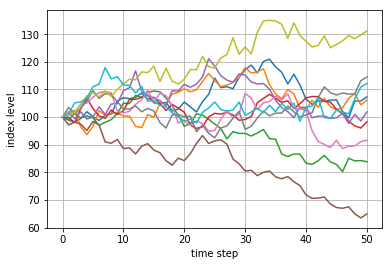

In [37]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
plt.plot(S[:, :10]);
plt.grid(True);
plt.xlabel('time step');
plt.ylabel('index level');

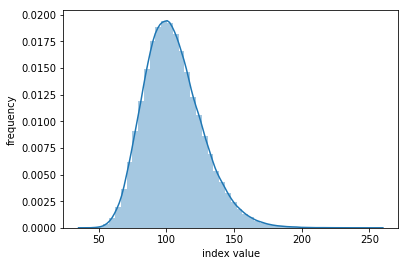

In [53]:
ax = sns.distplot(S[-1], bins= 50, axlabel='index value');
ax.set_ylabel('frequency');



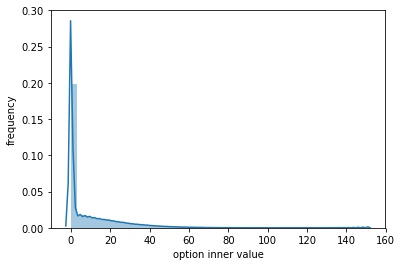

In [56]:
ax = sns.distplot(np.maximum(S[-1] - K, 0), bins=50)
ax.set_xlabel('option inner value')
ax.set_ylabel('frequency')
# ax.set_ylim(0, 5000)